In [87]:
# imports 
from pyforest import *
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from datetime import datetime
import gc
import warnings
warnings.filterwarnings('ignore')
lazy_imports()

['import pydot',
 'from sklearn.ensemble import RandomForestRegressor',
 'import pickle',
 'from sklearn.linear_model import RidgeCV',
 'from sklearn.preprocessing import MinMaxScaler',
 'import fastai',
 'import spacy',
 'import glob',
 'import bokeh',
 'from sklearn.ensemble import GradientBoostingClassifier',
 'from sklearn.model_selection import KFold',
 'import awswrangler as wr',
 'from sklearn.model_selection import RandomizedSearchCV',
 'from sklearn.linear_model import Lasso',
 'from scipy import signal as sg',
 'from sklearn.decomposition import PCA',
 'import nltk',
 'from openpyxl import load_workbook',
 'import plotly.express as px',
 'from sklearn.model_selection import train_test_split',
 'import keras',
 'from sklearn.manifold import TSNE',
 'import cv2',
 'from sklearn.preprocessing import LabelEncoder',
 'from sklearn import svm',
 'import fbprophet',
 'import xgboost as xgb',
 'from pathlib import Path',
 'import torch',
 'from sklearn.model_selection import cross_va

In [88]:
# read csv and date parser

import datetime, pytz
#define a conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

df_bit = pd.read_csv('../dataset/coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11.csv', header = 0
                 , parse_dates = [0], date_parser = dateparse, index_col = 0)
df_bit.head()

<IPython.core.display.Javascript object>

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2014-11-30 21:33:00+00:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0
2014-11-30 21:34:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-30 21:35:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-30 21:36:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-30 21:37:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
# df info
df_bit.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2016354 entries, 2014-11-30 21:33:00+00:00 to 2018-11-10 16:00:00+00:00
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Open               float64
 1   High               float64
 2   Low                float64
 3   Close              float64
 4   Volume_(BTC)       float64
 5   Volume_(Currency)  float64
 6   Weighted_Price     float64
dtypes: float64(7)
memory usage: 123.1 MB


In [90]:
df_bit.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2018-11-10 15:56:00+00:00,6347.41,6347.42,6347.41,6347.42,0.484960,3078.241490,6347.417225
2018-11-10 15:57:00+00:00,6347.41,6347.42,6347.41,6347.42,0.770757,4892.318043,6347.419294
2018-11-10 15:58:00+00:00,6347.41,6347.42,6347.41,6347.42,1.213145,7700.341614,6347.418653
2018-11-10 15:59:00+00:00,6347.41,6347.42,6347.41,6347.42,1.714091,10880.053958,6347.418881
2018-11-10 16:00:00+00:00,6347.42,6347.42,6347.41,6347.42,0.489324,3105.944897,6347.417439


In [91]:
# start and end time stamp
start = min(df_bit.index)
end = max(df_bit.index)
print(start,end)

2014-11-30 21:33:00+00:00 2018-11-10 16:00:00+00:00


In [92]:
# null values
df_bit.isna().sum()

Open                 108957
High                 108957
Low                  108957
Close                108957
Volume_(BTC)         108957
Volume_(Currency)    108957
Weighted_Price       108957
dtype: int64

In [93]:
# saving formatted csv
#df_bit.to_csv('../dataset/bitcoin.csv')

In [94]:
# creating copy of the dataframe
df_bit2 = df_bit.copy()

"""based on the analysis, the volumns are individual events, they do not increment over time,
so we will fill na values with zero"""

df_bit2['Volume_(BTC)'] = df_bit2['Volume_(BTC)'].fillna(value = 0)
df_bit2['Volume_(Currency)'] = df_bit2['Volume_(Currency)'].fillna(value = 0)

df_bit2['Weighted_Price'] = df_bit2['Weighted_Price'].fillna(method = 'bfill')

"""The following parameters are incremented/ dependent on each time steps,
hence we will fill na values with backward fill """

df_bit2['Open'] = df_bit2['Open'].fillna(method = 'bfill')
df_bit2['High'] = df_bit2['High'].fillna(method = 'bfill')
df_bit2['Low'] = df_bit2['Low'].fillna(method = 'bfill')
df_bit2['Close'] = df_bit2['Close'].fillna(method = 'bfill')

df_bit2.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2014-11-30 21:33:00+00:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0
2014-11-30 21:34:00+00:00,300.0,300.0,300.0,300.0,0.00,0.0,300.0
2014-11-30 21:35:00+00:00,300.0,300.0,300.0,300.0,0.00,0.0,300.0
2014-11-30 21:36:00+00:00,300.0,300.0,300.0,300.0,0.00,0.0,300.0
2014-11-30 21:37:00+00:00,300.0,300.0,300.0,300.0,0.00,0.0,300.0


In [95]:
# revalidating the missing values
df_bit2.isna().sum()

Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [96]:
# saving preprocessed dataset
#df_bit2.to_csv('../dataset/bitcoin_data_preprocessed.csv',index =True)

In [97]:
# changing frequency to weekly ( every monday)

weekly_bit = df_bit2.groupby([pd.Grouper(level = 'Timestamp' , freq = 'W-MON',dropna = True)]).first()
weekly_bit.head()

<IPython.core.display.Javascript object>

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2014-12-01 00:00:00+00:00,300.00,300.0,300.00,300.0,0.01,3.00,300.000000
2014-12-08 00:00:00+00:00,377.75,378.0,377.75,378.0,0.00,0.00,377.984375
2014-12-15 00:00:00+00:00,398.00,398.0,398.00,398.0,0.01,3.98,398.000000
2014-12-22 00:00:00+00:00,345.00,345.0,340.00,340.0,2.00,685.00,342.500000
2014-12-29 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
### correlation among each variable using pearson
weekly_bit.corr()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Open,1.000000,0.999999,1.000000,0.999999,0.154146,0.401361,0.999999
High,0.999999,1.000000,0.999999,1.000000,0.154996,0.402553,1.000000
Low,1.000000,0.999999,1.000000,0.999999,0.154105,0.401354,1.000000
Close,0.999999,1.000000,0.999999,1.000000,0.154957,0.402544,1.000000
Volume_(BTC),0.154146,0.154996,0.154105,0.154957,1.000000,0.703546,0.154653
Volume_(Currency),0.401361,0.402553,0.401354,0.402544,0.703546,1.000000,0.402091
Weighted_Price,0.999999,1.000000,1.000000,1.000000,0.154653,0.402091,1.000000


we can use the Open,High,Low,Close as exog

In [99]:
# visualization of open , close and weighted price
trace1 = go.Scatter(
    x = weekly_bit.index,
    y = weekly_bit['Open'].astype(float),
    mode = 'lines',
    name = 'Open'
)

trace2 = go.Scatter(
    x = weekly_bit.index,
    y = weekly_bit['High'].astype(float),
    mode = 'lines',
    name = 'High'
)

trace3 = go.Scatter(
    x = weekly_bit.index,
    y = weekly_bit['Low'].astype(float),
    mode = 'lines',
    name = 'Low'
)

trace4 = go.Scatter(
    x = weekly_bit.index,
    y = weekly_bit['Close'].astype(float),
    mode = 'lines',
    name = 'Close'
)

trace5 = go.Scatter(
    x = weekly_bit.index,
    y = weekly_bit['Weighted_Price'].astype(float),
    mode = 'lines',
    name = 'Weighted Average'
)

layout = dict(
    title='Historical Bitcoin Prices (2014/12/30-2018/11/12) with the Slider ',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1,trace2, trace3, trace4, trace5]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [100]:
# visualization of btc and weighted
trace1 = go.Scatter(
    x = weekly_bit.index,
    y = weekly_bit['Volume_(BTC)'].astype(float),
    mode = 'lines',
    name = 'Volume_(BTC)'
)

trace2 = go.Scatter(
    x = weekly_bit.index,
    y = weekly_bit['Volume_(Currency)'].astype(float),
    mode = 'lines',
    name = 'Volume_(Currency)'
)

trace3 = go.Scatter(
    x = weekly_bit.index,
    y = weekly_bit['Weighted_Price'].astype(float),
    mode = 'lines',
    name = 'Weighted Average'
)

layout = dict(
    title='Historical Bitcoin USD and BTC (2014/12/30-2018/11/12) with the Slider ',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1, trace2, trace3]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider2")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

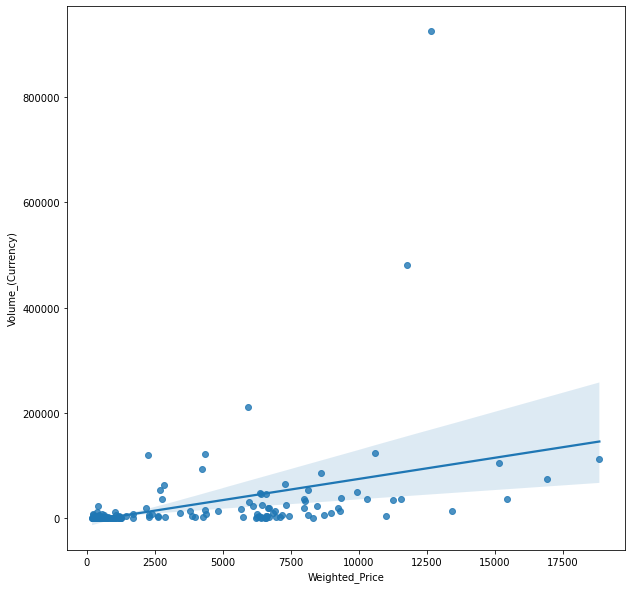

In [101]:
# Volume_(Currency) vs USD visualization
plt.figure(figsize = (10,10))
sns.regplot(data = weekly_bit, x = 'Weighted_Price', y = 'Volume_(Currency)')
plt.show()

In [102]:
# data prep for model input
# resampling data into daily and hourly again for seasonal decompose and analysis
data_prep = df_bit2.copy()
data_prep_hourly = data_prep.groupby(pd.Grouper(level = 'Timestamp', freq = 'H')).first()
data_prep_daily = data_prep.groupby(pd.Grouper(level = 'Timestamp', freq = 'D')).first()

data_prep_hourly['Weighted_Price'] = data_prep_hourly['Weighted_Price'].replace(0,np.nan)
data_prep_hourly['Weighted_Price'] = data_prep_hourly['Weighted_Price'].fillna(method = 'bfill')
data_prep_daily['Weighted_Price'] = data_prep_daily['Weighted_Price'].replace(0,np.nan)
data_prep_daily['Weighted_Price'] = data_prep_daily['Weighted_Price'].fillna(method = 'bfill')

data_prep_hourly['Volume_(BTC)'] = data_prep_hourly['Volume_(BTC)'].fillna(0)
data_prep_daily['Volume_(BTC)'] = data_prep_daily['Volume_(BTC)'].fillna(0)

data_prep_hourly['Volume_(Currency)'] = data_prep_hourly['Volume_(Currency)'].fillna(0)
data_prep_daily['Volume_(Currency)'] = data_prep_daily['Volume_(Currency)'].fillna(0)

# our target = weighted price
data_prep_daily = data_prep_daily[['Volume_(BTC)','Volume_(Currency)','Weighted_Price']]
display(data_prep_hourly.head(10),data_prep_daily.head(10))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2014-11-30 21:00:00+00:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0
2014-11-30 22:00:00+00:00,370.0,370.0,370.0,370.0,0.00,0.0,370.0
2014-11-30 23:00:00+00:00,377.0,377.0,377.0,377.0,0.00,0.0,377.0
2014-12-01 00:00:00+00:00,377.0,377.0,377.0,377.0,0.00,0.0,377.0
2014-12-01 01:00:00+00:00,377.0,377.0,377.0,377.0,0.00,0.0,377.0
2014-12-01 02:00:00+00:00,377.0,377.0,377.0,377.0,0.00,0.0,377.0
2014-12-01 03:00:00+00:00,377.0,377.0,377.0,377.0,0.00,0.0,377.0
2014-12-01 04:00:00+00:00,377.0,377.0,377.0,377.0,0.00,0.0,377.0
2014-12-01 05:00:00+00:00,377.0,377.0,377.0,377.0,0.00,0.0,377.0


,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,
2014-11-30 00:00:00+00:00,0.010,3.0000,300.000000
2014-12-01 00:00:00+00:00,0.000,0.0000,377.000000
2014-12-02 00:00:00+00:00,0.000,0.0000,377.984375
2014-12-03 00:00:00+00:00,0.000,0.0000,378.000000
2014-12-04 00:00:00+00:00,0.000,0.0000,378.000000
2014-12-05 00:00:00+00:00,0.015,5.6700,378.000000
2014-12-06 00:00:00+00:00,0.000,0.0000,375.000426
2014-12-07 00:00:00+00:00,0.000,0.0000,375.000426
2014-12-08 00:00:00+00:00,0.235,88.1251,375.000426


In [103]:
# saving clean dataset
data_prep_daily.to_csv('../dataset/data_daily_clean.csv',index = False)
data_prep_hourly.to_csv('../dataset/data_hourly_clean.csv',index = False)

In [17]:
# data divison (05-jun-2018) as raise started after major dip (DAILY)
data_division = '2018-06-04'
bit_train = data_prep_daily[data_prep_daily.index <= data_division]
bit_test = data_prep_daily[data_prep_daily.index > data_division]
bit_train.head()

,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,
2014-11-30 00:00:00+00:00,0.01,3.0,300.000000
2014-12-01 00:00:00+00:00,0.00,0.0,377.000000
2014-12-02 00:00:00+00:00,0.00,0.0,377.984375
2014-12-03 00:00:00+00:00,0.00,0.0,378.000000
2014-12-04 00:00:00+00:00,0.00,0.0,378.000000


In [18]:
bit_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1283 entries, 2014-11-30 00:00:00+00:00 to 2018-06-04 00:00:00+00:00
Freq: D
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Volume_(BTC)       1283 non-null   float64
 1   Volume_(Currency)  1283 non-null   float64
 2   Weighted_Price     1283 non-null   float64
dtypes: float64(3)
memory usage: 40.1 KB


<IPython.core.display.Javascript object>

Dickey–Fuller test: p=0.448362


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

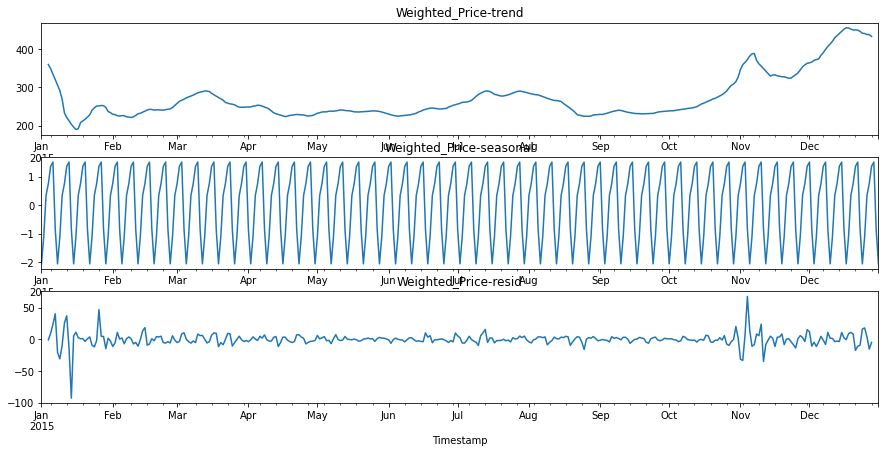

In [19]:
# seasonal decompose 
plt.figure(figsize=[15,7])
bit_train_2015 = bit_train[(bit_train.index >= '2015-01-01') & (bit_train.index <= '2015-12-31')]
result_decompose = sm.tsa.seasonal_decompose(bit_train_2015.Weighted_Price
                                             ,model = 'additive')
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(bit_train.Weighted_Price)[1])

plt.subplot(311)
result_decompose.trend.plot()
plt.title("Weighted_Price-trend")

plt.subplot(312)
result_decompose.seasonal.plot()
plt.title("Weighted_Price-seasonal")

plt.subplot(313)
result_decompose.resid.plot()
plt.title("Weighted_Price-resid")

plt.show()

The Autocorrelation plot for the data is:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

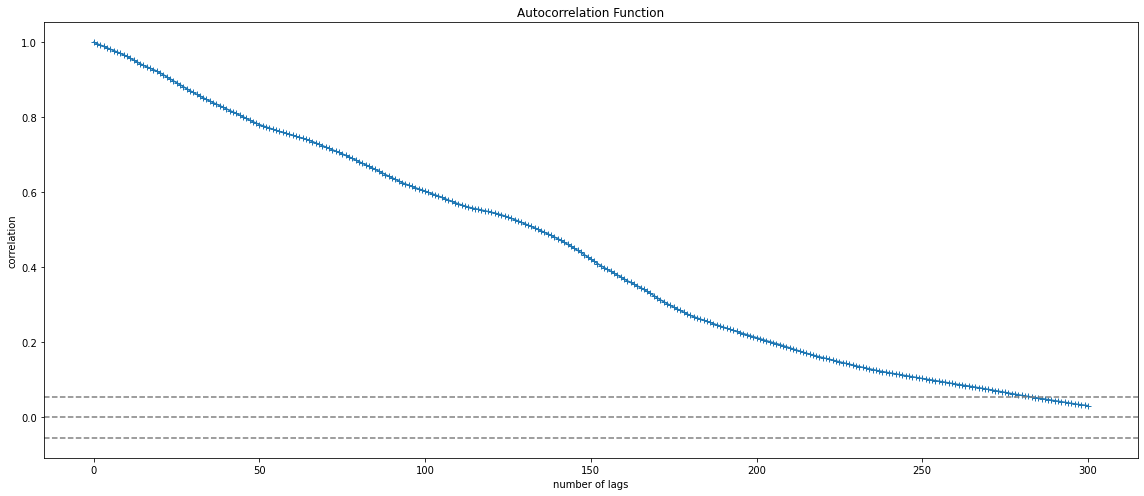

In [38]:
#### auto correlation plot
from statsmodels.tsa.stattools import acf, pacf
# Displaying the plot.
print("The Autocorrelation plot for the data is:")

"""sm.graphics.tsa.plot_acf(bit_train['Weighted_Price'], lags=40)
plt.figure(figsize=[15,7])
plt.show()"""

#calling auto correlation function
lag_acf = acf(bit_train['Weighted_Price'], nlags=300)
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_acf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(bit_train['Weighted_Price'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(bit_train['Weighted_Price'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()


<IPython.core.display.Javascript object>

Dickey–Fuller test: p=0.000000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

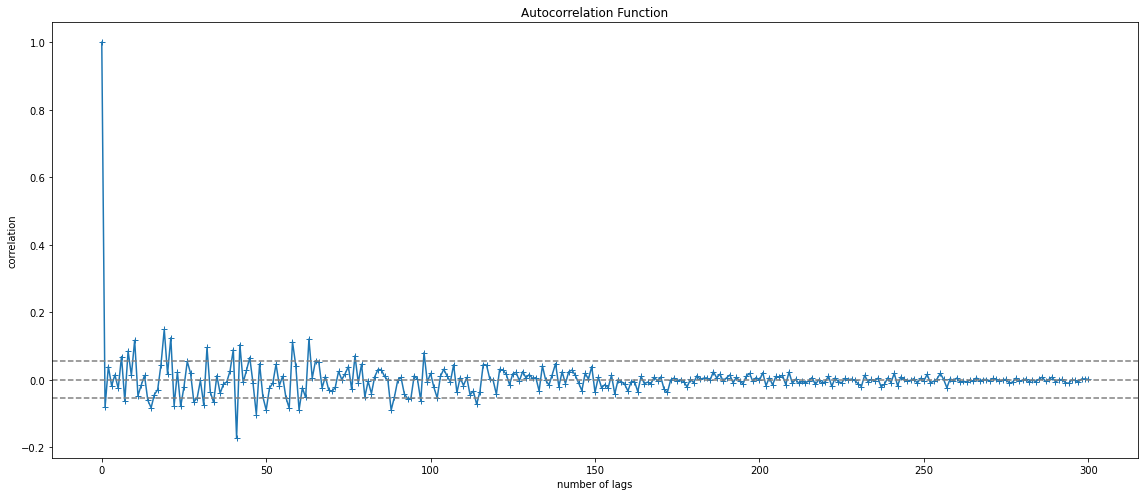

In [52]:
#### autocorrelation after differencing
bit_train['Weighted_Price_diff1'] = bit_train['Weighted_Price'].diff()
bit_train['Weighted_Price_diff1'] = bit_train['Weighted_Price_diff1'].replace(np.nan,0)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(bit_train.Weighted_Price_diff1)[1])
#calling auto correlation function
lag_acf = acf(bit_train['Weighted_Price_diff1'], nlags=300)
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_acf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(bit_train['Weighted_Price_diff1'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(bit_train['Weighted_Price_diff1'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

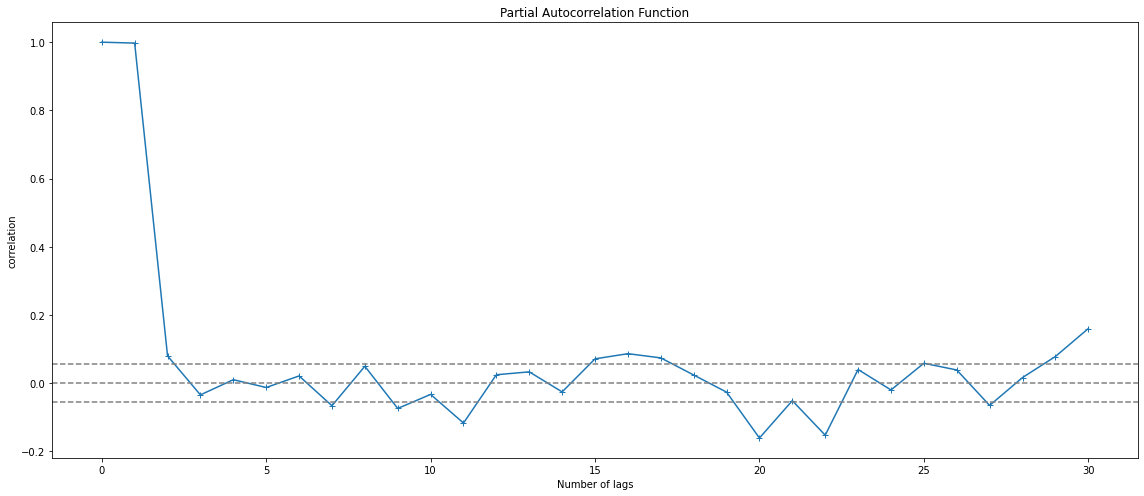

In [39]:
#calling partial correlation function
lag_pacf = pacf(bit_train['Weighted_Price'], nlags=30, method='ols')
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(bit_train['Weighted_Price'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(bit_train['Weighted_Price'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.tight_layout()

In [20]:
# Box-Cox Transformations (cannot perform, our data has a lot of zeros)
# bit_train['Weighted_Price_box'], lmbda = stats.boxcox(bit_train.Weighted_Price)
# print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(bit_train.Weighted_Price_box)[1])

In [53]:
import random
random.seed(13)
prior_model = auto_arima(bit_train['Weighted_Price'],exogenous = bit_train[['Volume_(Currency)','Volume_(BTC)']]
                         ,seasonal = True,m = 7,trace = True,stationary=False,n_jobs=-1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=18273.469, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=18271.050, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=18265.391, Time=0.29 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=18265.260, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=26162.728, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=18266.232, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=18267.974, Time=1.14 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=18261.849, Time=0.56 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=18260.098, Time=0.81 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=18262.436, Time=0.86 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=18249.244, Time=0.98 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=18260.719, Time=0.83 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=18265.662, Time=0.37 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=18255.210, Time=1.06 sec
 ARIMA(1,1,1)(2,0,1

In [54]:
prior_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1283
Model:             SARIMAX(1, 1, 0)x(2, 0, [1], 7)   Log Likelihood               -9116.713
Date:                             Tue, 26 Jul 2022   AIC                          18247.425
Time:                                     20:18:45   BIC                          18283.518
Sample:                                 11-30-2014   HQIC                         18260.977
                                      - 06-04-2018                                         
Covariance Type:                               opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Volume_(Currency)    -0.0003      0.000     -2.122      0.034      -0.001   -2.17e-05
Volume_(BTC)         -0.3768      1.426     -0.264      0.792      -3.172       2.418
ar.L1                -0.0813      0.010     -8.078      0.000      -0.101      -0.062
ar.S.L7              -0.7665      0.050    -15.463      0.000      -0.864      -0.669
ar.S.L14             -0.1196      0.012     -9.788      0.000      -0.144      -0.096
ma.S.L7               0.7290      0.049     14.917      0.000       0.633       0.825
sigma2             8.963e+04    974.311     91.995      0.000    8.77e+04    9.15e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             56194.18
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):            1270.16   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        35.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.87e+14. Standard errors may be unstable.
"""

In [55]:
# train test and model fit
import random
random.seed(13)
best_model = auto_arima(bit_train['Weighted_Price'],exogenous = bit_train[['Volume_(Currency)']],seasonal = True,
           m = 7,trace = True,stationary=False,n_jobs=-1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=18271.907, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=18269.245, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=18263.668, Time=0.24 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=18263.530, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=26160.923, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=18264.484, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=18260.290, Time=1.05 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=18263.931, Time=0.30 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=18247.698, Time=0.94 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=18258.963, Time=0.41 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=18260.778, Time=0.72 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=18258.437, Time=0.76 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=18253.583, Time=0.69 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=18249.267, Time=0.93 sec
 ARIMA(0,1,2)(2,0,1

In [56]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1283
Model:             SARIMAX(1, 1, 0)x(2, 0, [1], 7)   Log Likelihood               -9116.949
Date:                             Tue, 26 Jul 2022   AIC                          18245.898
Time:                                     20:22:23   BIC                          18276.836
Sample:                                 11-30-2014   HQIC                         18257.514
                                      - 06-04-2018                                         
Covariance Type:                               opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Volume_(Currency)    -0.0003   4.02e-05     -8.187      0.000      -0.000      -0.000
ar.L1                -0.0807      0.010     -8.175      0.000      -0.100      -0.061
ar.S.L7              -0.7583      0.051    -14.984      0.000      -0.857      -0.659
ar.S.L14             -0.1198      0.012    -10.046      0.000      -0.143      -0.096
ma.S.L7               0.7206      0.050     14.405      0.000       0.623       0.819
sigma2             8.965e+04    930.323     96.364      0.000    8.78e+04    9.15e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             56025.13
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):            1414.68   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        35.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<IPython.core.display.Javascript object>

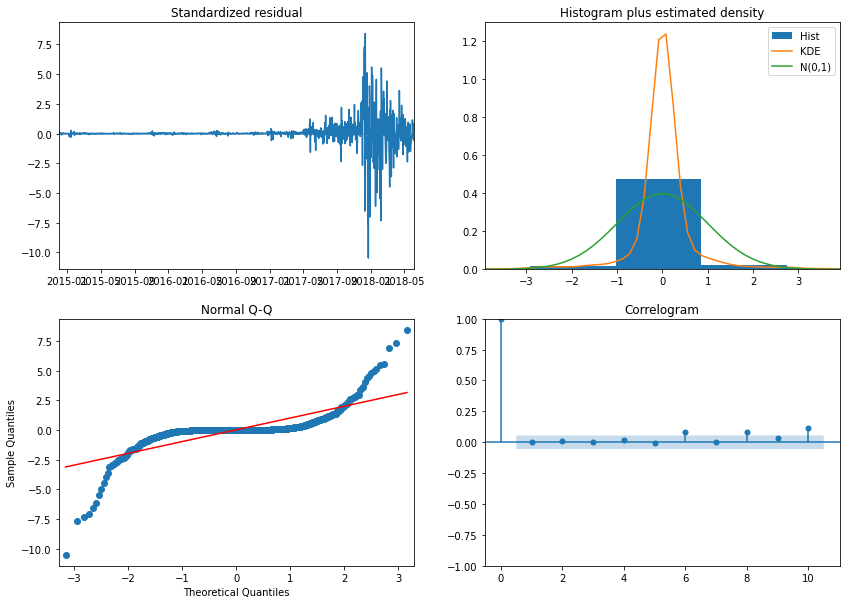

In [57]:
# Analysis of residues for autoarima
best_model.plot_diagnostics(figsize=(14,10))
plt.show()

In [64]:
# train our sarimax model with exogenous variable

model = SARIMAX(bit_train['Weighted_Price'],exog = bit_train[['Volume_(Currency)']],
                   order = (1,1,0), seasonal_order = (2,0,1,7)).fit()
model.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.10613D+00    |proj g|=  2.55697D+00


 This problem is unconstrained.



At iterate    5    f=  7.10598D+00    |proj g|=  1.19607D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     35      1     0     0   1.744D-03   7.106D+00
  F =   7.1059619829247449     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      Weighted_Price   No. Observations:                 1283
Model:             SARIMAX(1, 1, 0)x(2, 0, [1], 7)   Log Likelihood               -9116.949
Date:                             Tue, 26 Jul 2022   AIC                          18245.898
Time:                                     20:29:33   BIC                          18276.836
Sample:                                 11-30-2014   HQIC                         18257.514
                                      - 06-04-2018                                         
Covariance Type:                               opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Volume_(Currency)    -0.0003   4.02e-05     -8.187      0.000      -0.000      -0.000
ar.L1                -0.0807      0.010     -8.175      0.000      -0.100      -0.061
ar.S.L7              -0.7583      0.051    -14.984      0.000      -0.857      -0.659
ar.S.L14             -0.1198      0.012    -10.046      0.000      -0.143      -0.096
ma.S.L7               0.7206      0.050     14.405      0.000       0.623       0.819
sigma2             8.965e+04    930.323     96.364      0.000    8.78e+04    9.15e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             56025.13
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):            1414.68   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        35.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dickey–Fuller test:: p=0.000000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

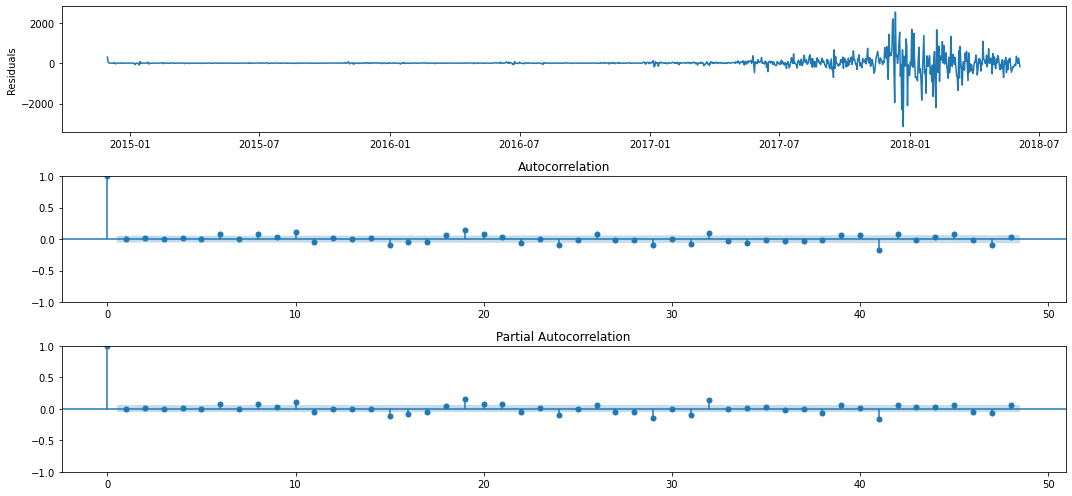

In [65]:
# Analysis of residues
plt.figure(figsize=(15,7))
plt.subplot(311)
plt.plot(model.resid)
plt.ylabel(u'Residuals')
ax = plt.subplot(312)
sm.graphics.tsa.plot_acf(model.resid, lags=48, ax=ax)
ax = plt.subplot(313)
sm.graphics.tsa.plot_pacf(model.resid, lags=48, ax=ax)
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(model.resid)[1])
plt.tight_layout()
plt.show()

In [72]:
(len(bit_train)+len(bit_test) ) - len(bit_train)

159

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

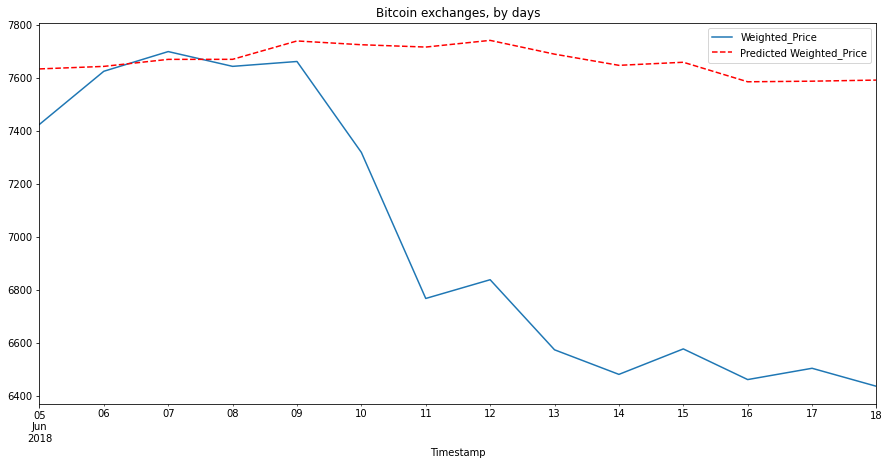

In [75]:
# prediction test
bit_test['forecast'] = model.predict(start = len(bit_train),end = (len(bit_train)+len(bit_test)-1)
                                     ,exog = bit_test['Volume_(Currency)'])
plt.figure(figsize=(15,7))
bit_test.Weighted_Price[:14].plot()
bit_test.forecast[:14].plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by days')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

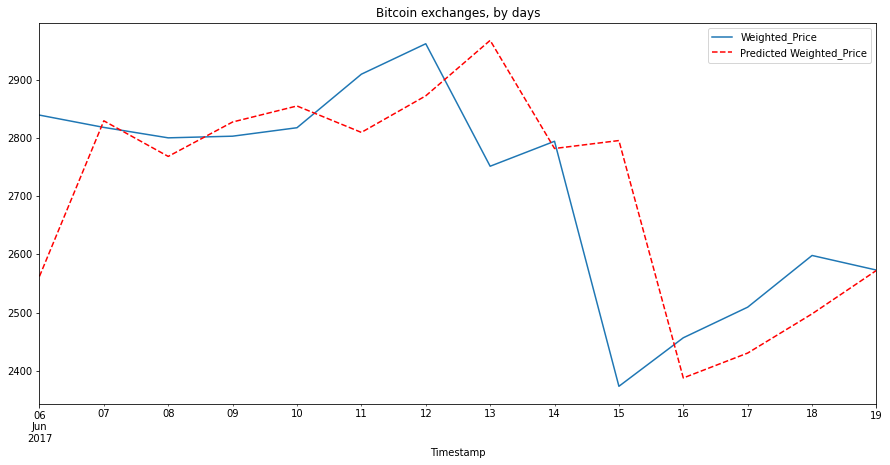

In [83]:
# prediction train
bit_train['forecast'] = model.predict(start = 0,end = (len(bit_train)-1),exog = bit_test['Volume_(Currency)'])
plt.figure(figsize=(15,7))
bit_train.Weighted_Price[919:933].plot()
bit_train.forecast[919:933].plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by days')
plt.show()

In [84]:
# evaluation
# test
print(np.sqrt(metrics.mean_squared_error(bit_test['forecast'],bit_test['Weighted_Price'])))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1106.3550678400807


In [85]:
# train
print(np.sqrt(metrics.mean_squared_error(bit_train['forecast'],bit_train['Weighted_Price'])))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

296.58868968220224


In [86]:
# mean
bit_test['Weighted_Price'].mean()

6674.832922262264